In [3]:
%load_ext autoreload
%autoreload 2

import os
from functions import import_orderbooks
import pandas as pd
import numpy as np
import coremltools as ct
from sklearn.preprocessing import MinMaxScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [4]:
orderbooks_path = r"/Users/johannesseidel/Projekte/CryptoAI/OrderbookData/Bitcoin/"

# Laden der Bitcoin-Marktdaten
orderbook_data = import_orderbooks(orderbooks_path)

print("-> imported orderbook data:", orderbook_data)

-> reading orderbook files...


 62%|██████▏   | 91/146 [04:07<02:21,  2.57s/file]

<function matplotlib.pyplot.show(close=None, block=None)>

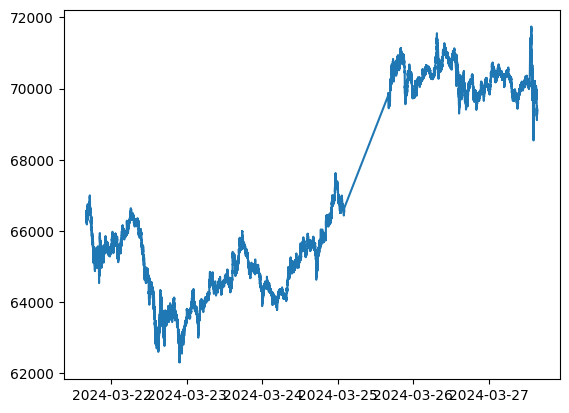

In [6]:
from matplotlib import pyplot as plt
plt.plot(orderbook_data["close"])
plt.show

In [7]:
# Datenvorverarbeitung
orderbook_data = orderbook_data.dropna()
orderbook_data = orderbook_data.sort_values('timestamp')

<function matplotlib.pyplot.show(close=None, block=None)>

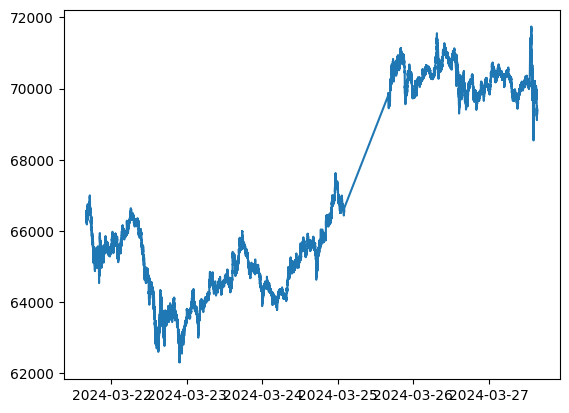

In [8]:
plt.plot(orderbook_data["close"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

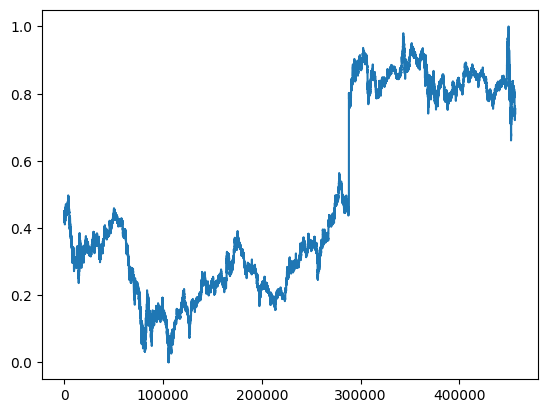

In [10]:
# Lade die Daten aus dem Pandas DataFrame
data = orderbook_data[['open', 'high', 'low', 'close', 'volume']]

# Skaliere die Daten auf den Bereich 0-1
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

plt.plot(data[:,3])
plt.show    

In [21]:
# Definiere die Größe des gleitenden Fensters und die Anzahl der Merkmale
window_size = 200
forecast_horizon = 60
n_features = data.shape[1]

# Erstelle die Trainings- und Testdaten
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)-forecast_horizon):
        X.append(data[i-window_size:i])
        y.append(data[i+forecast_horizon, 3])  # Verwende 'close' als Zielvariable aber bei +10s!
    return np.array(X), np.array(y)

def create_dataset_relativey(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)-forecast_horizon):
        X.append(data[i-window_size:i])
        y.append(data[i+forecast_horizon, 3]-data[i,3])  # Verwende 'close' als Zielvariable aber bei +10s!
    return np.array(X), np.array(y)

X, y = create_dataset_relativey(data, window_size)

print(X.shape)
print(y.shape)

(456380, 200, 5)
(456380,)


In [22]:
X = X[0:50000]
y = y[0:50000]
print(X.shape)
print(y.shape)

(50000, 200, 5)
(50000,)


In [23]:
# Teile die Daten in Trainings- und Testdaten auf
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(40000, 200, 5) (10000, 200, 5)
(40000,) (10000,)


In [24]:
# Definiere das LSTM-Modell mit CoreML
model = ct.models.neural_network.NeuralNetworkBuilder(
    input_features=[("input", ct.models.datatypes.Array(window_size, n_features))],
    output_features=[("output", ct.models.datatypes.Array(1))]
)

model.add_unilstm(
    name="lstm_1",
    W_h=ct.utils.load_weights("lstm_1_W_h", shape=(128, 128)),
    W_x=ct.utils.load_weights("lstm_1_W_x", shape=(n_features, 128)),
    b=ct.utils.load_weights("lstm_1_b", shape=(128,)),
    hidden_size=128,
    input_size=n_features,
    input_names=["input"],
    output_names=["lstm_1_output"],
    activation="TANH",
    peep=None,
    output_all=True
)

model.add_dropout(
    name="dropout_1",
    input_name="lstm_1_output",
    output_name="dropout_1_output",
    rate=0.2
)

model.add_unilstm(
    name="lstm_2",
    W_h=ct.utils.load_weights("lstm_2_W_h", shape=(64, 64)),
    W_x=ct.utils.load_weights("lstm_2_W_x", shape=(128, 64)),
    b=ct.utils.load_weights("lstm_2_b", shape=(64,)),
    hidden_size=64,
    input_size=128,
    input_names=["dropout_1_output"],
    output_names=["lstm_2_output"],
    activation="TANH",
    peep=None,
    output_all=True
)

model.add_dropout(
    name="dropout_2",
    input_name="lstm_2_output",
    output_name="dropout_2_output",
    rate=0.2
)

model.add_unilstm(
    name="lstm_3",
    W_h=ct.utils.load_weights("lstm_3_W_h", shape=(64, 64)),
    W_x=ct.utils.load_weights("lstm_3_W_x", shape=(64, 64)),
    b=ct.utils.load_weights("lstm_3_b", shape=(64,)),
    hidden_size=64,
    input_size=64,
    input_names=["dropout_2_output"],
    output_names=["lstm_3_output"],
    activation="TANH",
    peep=None,
    output_all=False
)

model.add_dropout(
    name="dropout_3",
    input_name="lstm_3_output",
    output_name="dropout_3_output",
    rate=0.2
)

model.add_inner_product(
    name="dense_1",
    W=ct.utils.load_weights("dense_1_W", shape=(64, 32)),
    b=ct.utils.load_weights("dense_1_b", shape=(32,)),
    input_name="dropout_3_output",
    output_name="dense_1_output",
    input_channels=64,
    output_channels=32,
    has_bias=True
)

model.add_activation(
    name="relu_1",
    non_linearity="RELU",
    input_name="dense_1_output",
    output_name="relu_1_output"
)

model.add_inner_product(
    name="dense_2",
    W=ct.utils.load_weights("dense_2_W", shape=(32, 1)),
    b=ct.utils.load_weights("dense_2_b", shape=(1,)),
    input_name="relu_1_output",
    output_name="output",
    input_channels=32,
    output_channels=1,
    has_bias=True
)

model.set_input(input_names=["input"], input_dims=[(window_size, n_features)])
model.set_output(output_names=["output"], output_dims=[(1,)])


# Kompiliere das CoreML-Modell
coreml_model = ct.models.MLModel(model.spec)

/Users/johannesseidel/Projekte/CryptoAI/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Trainiere das CoreML-Modell
coreml_model.fit({"input": X_train}, {"output": y_train})

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - loss: 2.7177e-04 - val_loss: 2.4262e-05
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - loss: 5.5518e-05 - val_loss: 2.4429e-05


In [26]:
# Evaluiere das CoreML-Modell auf den Testdaten
metrics = coreml_model.evaluate({"input": X_test}, {"output": y_test})
print(f'Test loss: {metrics["loss"]:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - loss: 4.2406e-05
Test loss: 0.0000


In [33]:
from functions import backtesting
backtesting_result_pnl, signals_all = backtesting(model, X_test[0:5000], forecast_horizon, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[2.5468878e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[2.8555747e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
SIGNAL: [[3.2119686e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
SIGNAL: [[3.590039e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SIGNAL: [[3.9722305e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
SIGNAL: [[4.3455046e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[4.7260895e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[5.10104e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[5.4448377e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[5.733641e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
SIGNAL: [[5.9543177e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SIGNAL: [[6.1044935e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
SIGNAL: [[6.1883824e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SIGNAL: [[6.2342966e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SIGNAL: [[6.2456354e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SIGNAL

0 (5000, 5)


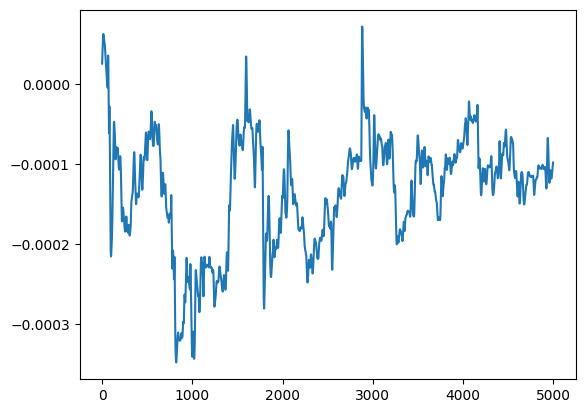

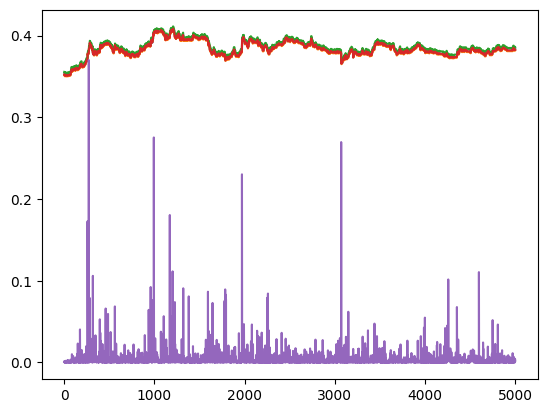

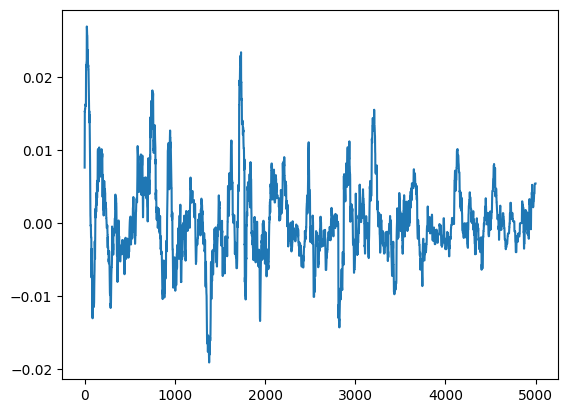

In [47]:
print(backtesting_result_pnl, X_test[0:5000, 3].shape)
signals_all_array = np.concatenate(signals_all, axis=0)
plt.plot(signals_all_array)
plt.show()
plt.plot(X_test[0:5000, 3])
plt.show()
plt.plot(y_test[0:5000])
plt.show()

DATEN: [[3.27308982e-01 3.27097867e-01 3.30565511e-01 3.27870936e-01
  3.86951418e-03]
 [3.27870224e-01 3.27480320e-01 3.31124347e-01 3.28253215e-01
  3.51228625e-03]
 [3.28252504e-01 3.27480320e-01 3.31504989e-01 3.28254274e-01
  4.44966827e-05]
 [3.28252504e-01 3.27480320e-01 3.31504989e-01 3.28254274e-01
  1.71935772e-05]
 [3.28253563e-01 3.27480320e-01 3.31506043e-01 3.28254274e-01
  5.06952256e-04]
 [3.28253563e-01 3.29170721e-01 3.31506043e-01 3.29947529e-01
  9.81745882e-03]
 [3.29946820e-01 3.29807791e-01 3.33192043e-01 3.30587133e-01
  4.96326183e-04]
 [3.30586424e-01 3.29808847e-01 3.33828905e-01 3.30588192e-01
  3.21881476e-04]
 [3.30586424e-01 3.29808847e-01 3.31716925e-01 3.28887524e-01
  2.29303287e-02]
 [3.28888931e-01 3.28114220e-01 3.32137634e-01 3.28888583e-01
  1.25889454e-04]
 [3.28887872e-01 3.28113164e-01 3.32137634e-01 3.28888583e-01
  2.51557531e-04]
 [3.28888931e-01 3.28114220e-01 3.32137634e-01 3.28888583e-01
  3.62393381e-04]
 [3.28888931e-01 3.28114220e-01 3

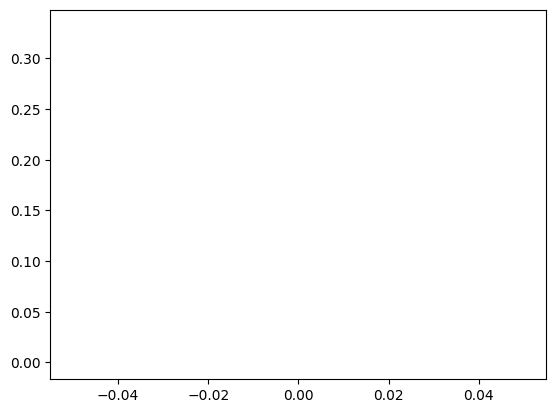

In [60]:
# model test variabel
pos = 14000

# Erstelle das Eingabefenster für die Vorhersage
input_data = data[pos-window_size:pos]

print("DATEN:",input_data, input_data.shape)
print("ERWARTETE AUSGABE:",data[pos+forecast_horizon][3])

input_data = np.expand_dims(input_data, axis=0)

# Überprüfe die Form der Eingabedaten
expected_shape = (None, window_size, data.shape[1])
if input_data.shape[1:] != expected_shape[1:]:
    raise ValueError(f"Ungültige Form der Eingabedaten. Erwartet: {expected_shape}, Tatsächlich: {input_data.shape}")


# Treffe eine Vorhersage mit dem Modell
prediction = model.predict(input_data)

scalerOut = MinMaxScaler()
dataOutScaled = scalerOut.fit_transform(data[:,3].reshape(-1, 1))

# Skaliere die Vorhersage zurück in den ursprünglichen Wertebereich
predicted_price = scalerOut.inverse_transform(prediction)[0]
print("AUSGABE PREDICTION:",predicted_price, "ODER", prediction)

plt.plot(input_data[:,3])
plt.show()

In [ ]:
#An Binance anbinden

from binance.client import Client
from tensorflow.keras.models import load_model

#Lade das trainierte Modell
#model = load_model('bitcoin_model.h5')

# Binance API Schlüssel
api_key = 'YOUR_API_KEY'
api_secret = 'YOUR_API_SECRET'

# Erstelle Binance Client
client = Client(api_key, api_secret)

# Definiere Handelsfunktionen
def buy_bitcoin(quantity):
    try:
        order = client.order_market_buy(symbol='BTCUSDT', quantity=quantity)
        print(f"Kaufauftrag ausgeführt: {order}")
    except Exception as e:
        print(f"Fehler beim Kaufauftrag: {e}")

def sell_bitcoin(quantity):
    try:
        order = client.order_market_sell(symbol='BTCUSDT', quantity=quantity)
        print(f"Verkaufsauftrag ausgeführt: {order}")
    except Exception as e:
        print(f"Fehler beim Verkaufsauftrag: {e}")

# Definiere Handelsstrategie
def trade_strategy(prediction):
    if prediction > 0.01:  # Wenn Kursanstieg von mehr als 1% vorhergesagt
        buy_bitcoin(0.001)  # Kaufe 0.001 BTC
    elif prediction < -0.01:  # Wenn Kursrückgang von mehr als 1% vorhergesagt
        sell_bitcoin(0.001)  # Verkaufe 0.001 BTC

# Hauptschleife für den Handel
while True:
    try:
        # Hole die letzten Kursdaten von der Binance API
        klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "100 minutes ago UTC")
        df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        df = df.astype(float)
        df = df[['open', 'high', 'low', 'close', 'volume']]

        # Skaliere die Daten
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)

        # Erstelle das Eingabefenster für die Vorhersage
        input_data = scaled_data[-100:]
        input_data = np.expand_dims(input_data, axis=0)

        # Treffe eine Vorhersage mit dem Modell
        prediction = model.predict(input_data)
        predicted_price = scaler.inverse_transform(prediction)[0][0]
        current_price = df['close'].iloc[-1]
        price_change = (predicted_price - current_price) / current_price

        # Führe die Handelsstrategie aus
        trade_strategy(price_change)

    except Exception as e:
        print(f"Fehler in der Hauptschleife: {e}")

    # Warte 1 Minute bis zur nächsten Iteration
    time.sleep(60)